#Import necessary libraries

In [ ]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation,Dense,Dropout,LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error,r2_score

#Get data from API

In [ ]:
url = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym=BTC&tsym=USD&limit=1000'
res=requests.get(url+'&api_key=7914f83e252f030f76e4d5b6dd83f99694292f397ca28d9ff82be31d3d792f12')
df = pd.DataFrame(json.loads(res.content)['Data']['Data'])
df = df.set_index('time')
df.index = pd.to_datetime(df.index,unit='s')
target_col='close'

#Exploratory Data Analysis

In [ ]:
df.head(5)

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2018-10-05,6683.55,6546.98,6580.00,39731.28,2.625623e+08,6632.87,direct,
2018-10-06,6637.08,6563.25,6632.88,24787.61,1.627221e+08,6589.94,direct,
2018-10-07,6622.49,6535.02,6589.94,27272.67,1.793789e+08,6601.15,direct,
2018-10-08,6698.31,6565.01,6601.46,47216.82,3.135074e+08,6650.07,direct,
2018-10-09,6657.00,6589.39,6650.07,32204.25,2.139767e+08,6631.79,direct,


In [ ]:
df.shape

(1001, 8)

In [ ]:
df.describe()

,high,low,open,volumefrom,volumeto,close
count,1001.000000,1001.000000,1001.000000,1001.000000,1.001000e+03,1001.000000
mean,15981.717443,14978.812587,15509.097712,52510.031399,8.559020e+08,15536.862647
std,15853.773651,14693.616258,15328.586027,37145.600887,1.141703e+09,15337.586359
min,3271.760000,3169.530000,3232.510000,5562.670000,5.672743e+07,3232.510000
25%,7204.930000,6689.070000,6879.440000,29187.080000,2.246807e+08,6887.600000
50%,9551.870000,9201.180000,9347.270000,42701.220000,3.843221e+08,9359.180000
75%,13314.050000,12797.050000,12990.250000,62123.130000,9.076654e+08,13041.210000
max,64859.810000,62038.330000,63558.480000,319316.540000,1.112022e+10,63558.480000


high                0
low                 0
open                0
volumefrom          0
volumeto            0
close               0
conversionType      0
conversionSymbol    0
dtype: int64


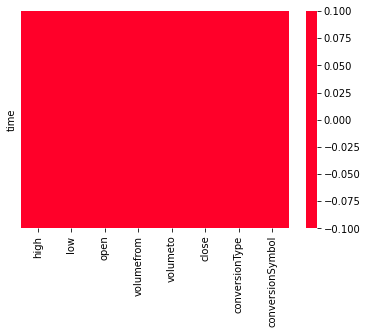

In [ ]:
print(df.isnull().sum())
sns.heatmap(df.isnull(),yticklabels=False,center=0,cmap='gist_rainbow')

In [ ]:
relation=df.corr()
relation

,high,low,open,volumefrom,volumeto,close
high,1.000000,0.998287,0.999170,0.091018,0.798943,0.999138
low,0.998287,1.000000,0.998372,0.055978,0.766703,0.998932
open,0.999170,0.998372,1.000000,0.080365,0.791189,0.998026
volumefrom,0.091018,0.055978,0.080365,1.000000,0.494808,0.075195
volumeto,0.798943,0.766703,0.791189,0.494808,1.000000,0.785022
close,0.999138,0.998932,0.998026,0.075195,0.785022,1.000000


[Text(0.5, 0, 'high'),
 Text(1.5, 0, 'low'),
 Text(2.5, 0, 'open'),
 Text(3.5, 0, 'volumefrom'),
 Text(4.5, 0, 'volumeto'),
 Text(5.5, 0, 'close')]

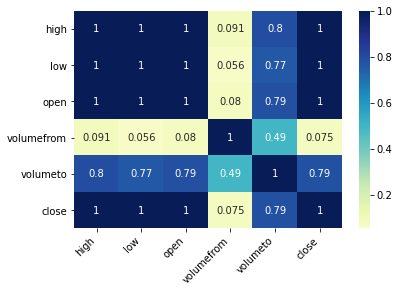

In [ ]:
heat_map=sns.heatmap(relation,annot=True,center=0.5,cmap='YlGnBu')
heat_map.set_xticklabels(heat_map.get_xticklabels(),rotation=45,horizontalalignment='right')

In [ ]:
df.nunique()

high                1001
low                 1000
open                1000
volumefrom          1001
volumeto            1001
close               1000
conversionType         1
conversionSymbol       1
dtype: int64

In [ ]:
df.dtypes

high                float64
low                 float64
open                float64
volumefrom          float64
volumeto            float64
close               float64
conversionType       object
conversionSymbol     object
dtype: object

In [ ]:
print(df.iloc[450])

high                    7540.65
low                     7295.33
open                    7316.23
volumefrom              18230.9
volumeto            1.35258e+08
close                   7399.49
conversionType           direct
conversionSymbol               
Name: 2019-12-29 00:00:00, dtype: object


In [ ]:
df[df['conversionType']=='invert_divide'].count()

high                0
low                 0
open                0
volumefrom          0
volumeto            0
close               0
conversionType      0
conversionSymbol    0
dtype: int64

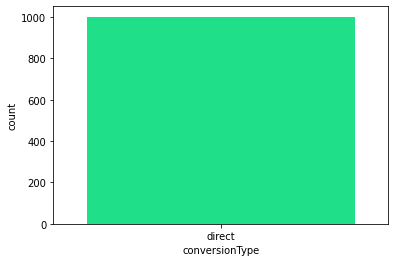

In [ ]:
sns.countplot(data=df,x='conversionType',palette='gist_rainbow')

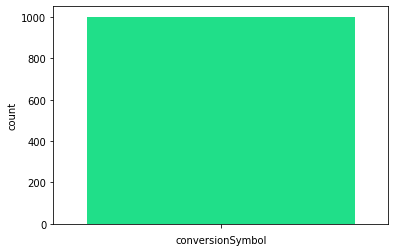

In [ ]:
sns.countplot(data=df,x='conversionSymbol',palette='gist_rainbow')

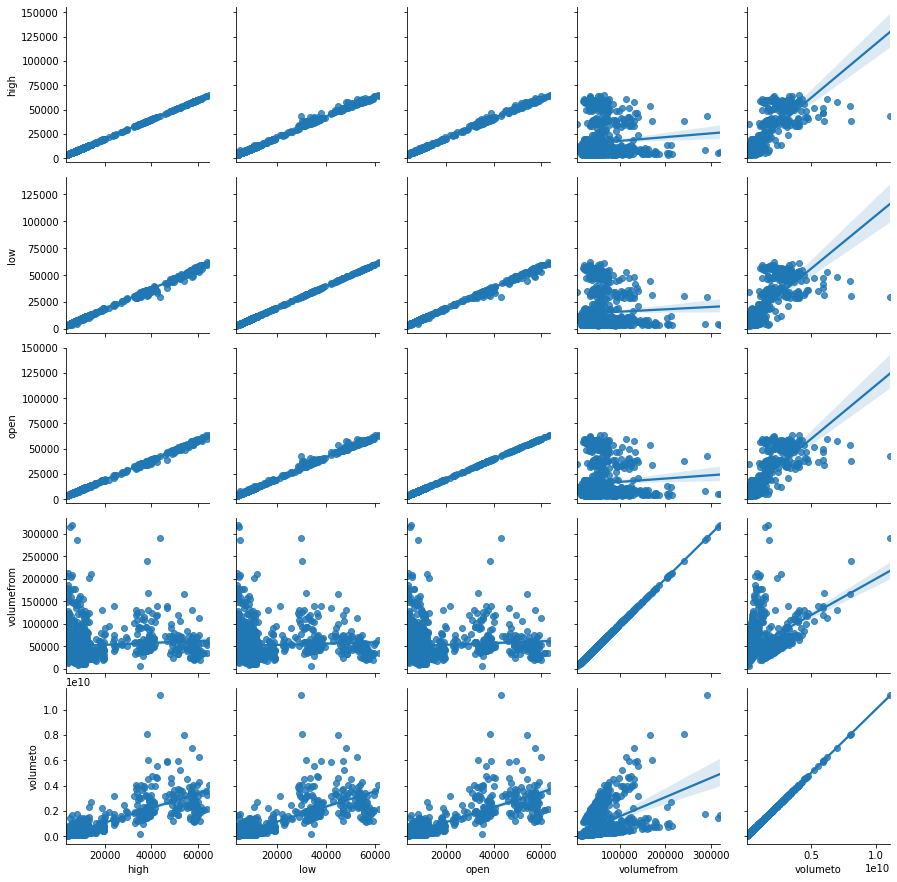

In [ ]:
fig=sns.PairGrid(data=df,vars=['high','low','open','volumefrom','volumeto'],palette='gist_rainbow')
fig.map(sns.regplot)

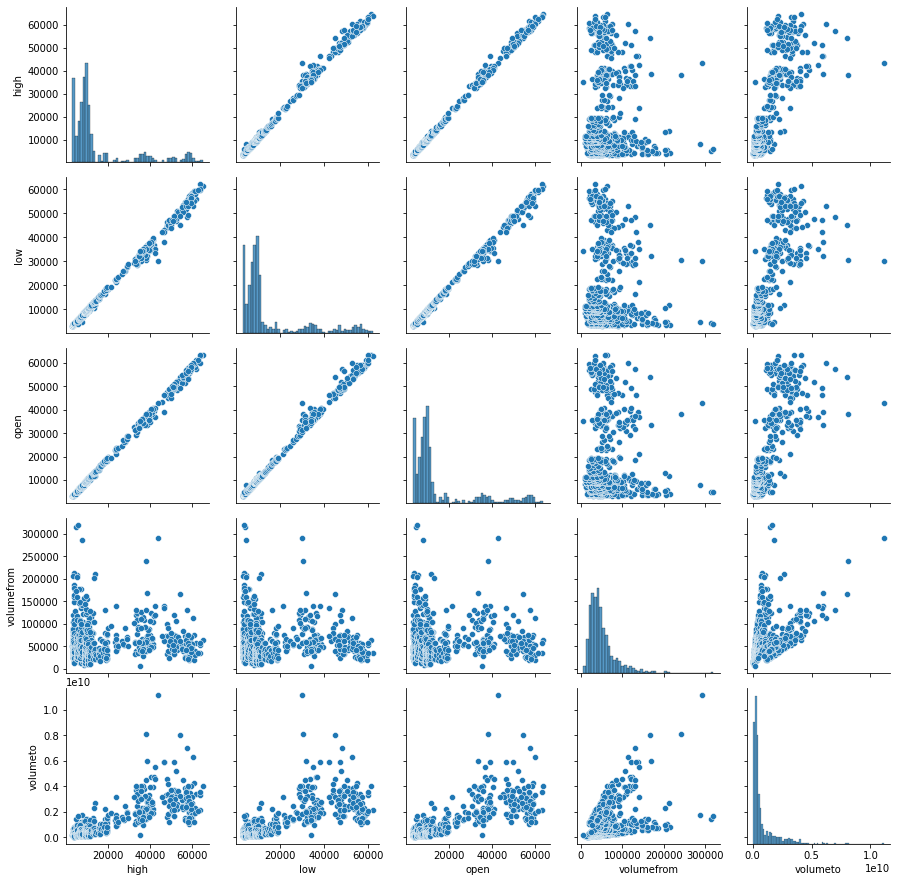

In [ ]:
fig=sns.PairGrid(data=df,vars=['high','low','open','volumefrom','volumeto'],palette='gist_rainbow')
fig.map_lower(sns.scatterplot)
fig.map_upper(sns.scatterplot)
fig.map_diag(sns.histplot)

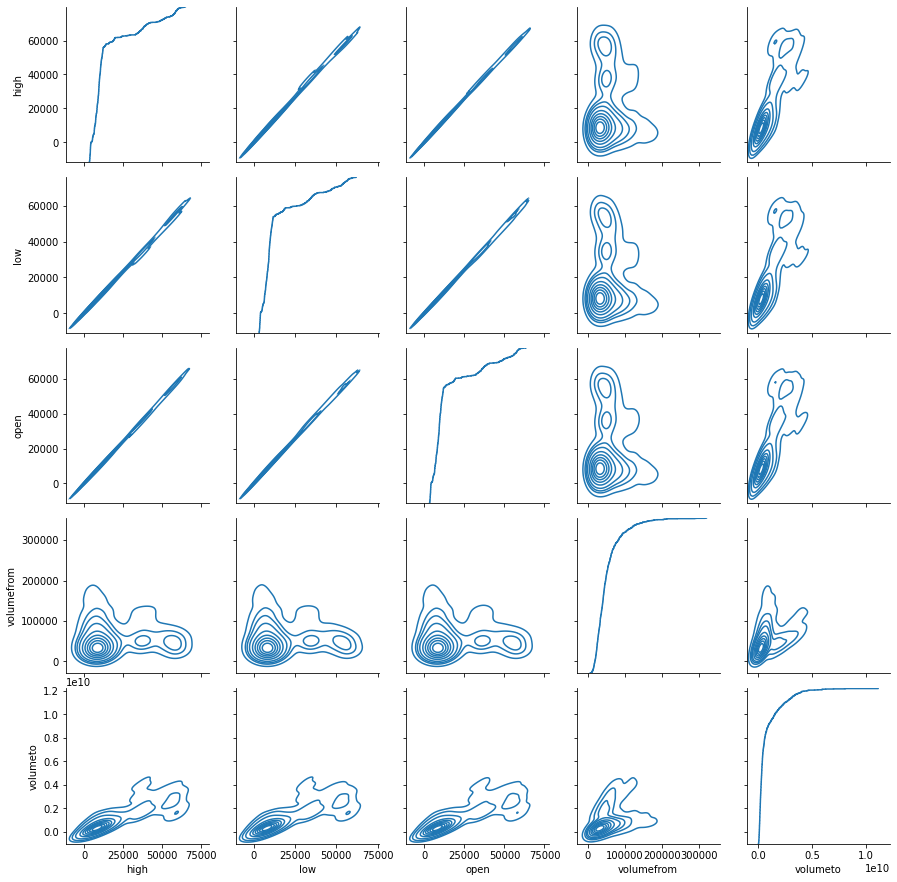

In [ ]:
fig=sns.PairGrid(data=df,vars=['high','low','open','volumefrom','volumeto'],palette='gist_rainbow')
fig.map_lower(sns.kdeplot)
fig.map_upper(sns.kdeplot)
fig.map_diag(sns.ecdfplot)

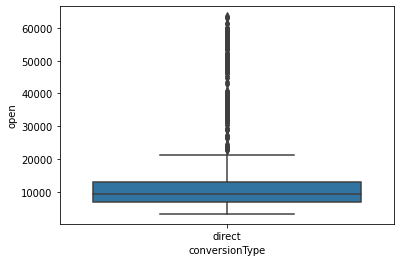

In [ ]:
sns.boxplot(x='conversionType',y='open',data=df)

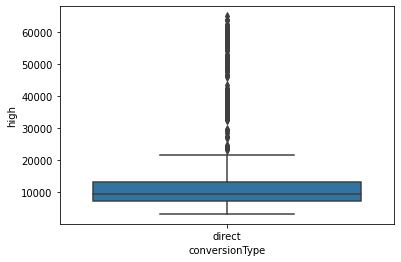

In [ ]:
sns.boxplot(x='conversionType',y='high',data=df)

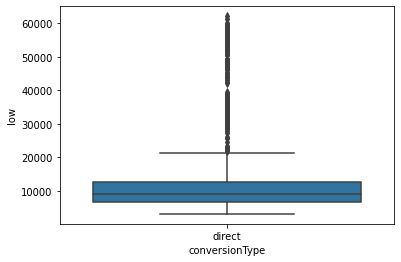

In [ ]:
sns.boxplot(x='conversionType',y='low',data=df)

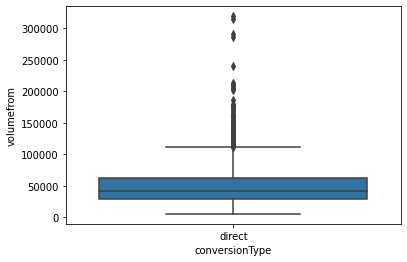

In [ ]:
sns.boxplot(x='conversionType',y='volumefrom',data=df)

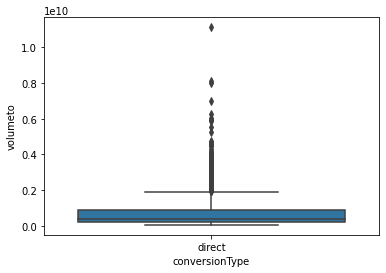

In [ ]:
sns.boxplot(x='conversionType',y='volumeto',data=df)

#Data Preparation

In [ ]:
df=df.drop(['conversionType','conversionSymbol'],axis='columns')

In [ ]:
def train_test_split(data,test_size=0.2):
  split_row=len(data)-int(len(data)*test_size)
  train_data=data.iloc[:split_row]
  test_data=data.iloc[split_row:]
  return train_data,test_data

In [ ]:
train,test = train_test_split(df,0.3)

In [ ]:
train.shape

(701, 6)

In [ ]:
test.shape

(300, 6)

In [ ]:
def line_plot(line1,line2,label1=None,label2=None,title='',lw=2):
  fig,ax=plt.subplots(1,figsize=(13,7))
  ax.plot(line1,label=label1,linewidth=lw)
  ax.plot(line2,label=label2,linewidth=lw)
  ax.set_ylabel('price [cad]',fontsize=16)
  ax.set_title(title,fontsize=18)
  ax.legend(loc='best',fontsize=18)

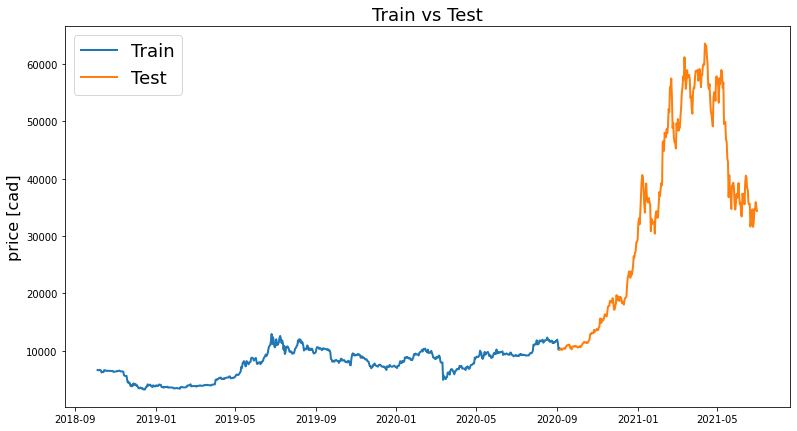

In [ ]:
line_plot(train[target_col],test[target_col],'Train','Test','Train vs Test')

Normalisation

In [ ]:
def normalise_zero_base(data):
  return data/data.iloc[0]-1
def normalise_min_max(data):
  return (data-data.min())/(data.max()-data.min())

Extract Window Length

In [ ]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

#Building our model

In [ ]:
def build_lstm_model(input_data,output_size,neurons=100,activ_func='linear',dropout=0.2,loss='mse',optimizer='adam'):
  model=Sequential()
  model.add(LSTM(neurons,input_shape=(input_data.shape[1],input_data.shape[2])))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))
  model.compile(loss=loss,optimizer=optimizer)
  return model

In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
25/25 [==============================] - 19s 7ms/step - loss: 0.0095
Epoch 2/20
25/25 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 3/20
25/25 [==============================] - 0s 5ms/step - loss: 0.0035
Epoch 4/20
25/25 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 5/20
25/25 [==============================] - 0s 6ms/step - loss: 0.0037
Epoch 6/20
25/25 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 7/20
25/25 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 8/20
25/25 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 9/20
25/25 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 10/20
25/25 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 11/20
25/25 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 12/20
25/25 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 13/20
25/25 [=============================

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(y_pred=preds,y_true= y_test)

0.04168388376829381

In [ ]:
preds.shape

(195,)

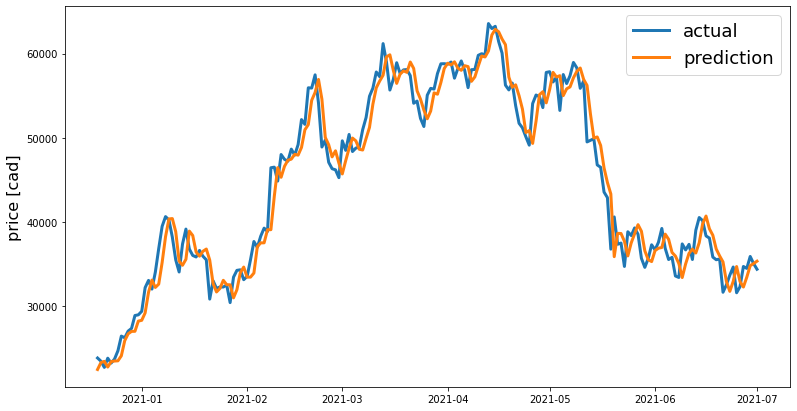

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [ ]:
print(targets)

time
2020-12-19    23844.72
2020-12-20    23467.06
2020-12-21    22727.13
2020-12-22    23823.32
2020-12-23    23239.50
                ...   
2021-06-27    34713.81
2021-06-28    34487.11
2021-06-29    35901.41
2021-06-30    35056.39
2021-07-01    34384.50
Name: close, Length: 195, dtype: float64


In [ ]:
print(test[target_col])

time
2020-12-14    19274.69
2020-12-15    19441.96
2020-12-16    21352.13
2020-12-17    22822.17
2020-12-18    23135.57
                ...   
2021-06-27    34713.81
2021-06-28    34487.11
2021-06-29    35901.41
2021-06-30    35056.39
2021-07-01    34384.50
Name: close, Length: 200, dtype: float64


In [ ]:
test[target_col].shape[0]

200

In [ ]:
test_price=pd.DataFrame((float(test[target_col][x]) for x in range(0,test[target_col].shape[0])))

In [ ]:
predict_price=pd.DataFrame((float(preds[x]) for x in range(0,preds.shape[0])))

In [ ]:
lstm_score=r2_score(test_price[:195],predict_price)
lstm_score*100

89.41657930715662

#Comparision with other models

In [ ]:
x=df.drop(target_col,axis='columns')

In [ ]:
y=df[target_col]

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest=RandomForestRegressor()
forest.fit(x_train,y_train)
forest_pred=forest.predict(x_test)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree=DecisionTreeRegressor()
tree.fit(x_train,y_train)
tree_pred=tree.predict(x_test)

In [ ]:
from sklearn.svm import SVR
svr=SVR()
svr.fit(x_train,y_train)
svr_pred=svr.predict(x_test)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knr=KNeighborsRegressor()
knr.fit(x_train,y_train)
knr_pred=knr.predict(x_test)

In [ ]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(x_train,y_train)
lr_pred=lr.predict(x_test)

In [ ]:
forest_score=r2_score(y_test,forest_pred)

In [ ]:
tree_score=r2_score(y_test,tree_pred)

In [ ]:
svr_score=r2_score(y_test,svr_pred)

In [ ]:
knr_score=r2_score(y_test,knr_pred)

In [ ]:
lr_score=r2_score(y_test,lr_pred)

In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
x_chart=np.array(['SVR','KNNR','LSTM'])
y_chart=np.array([svr_score,knr_score,lstm_score])

In [ ]:
print(y_chart)

[-0.15777299  0.75085397  0.89416579]


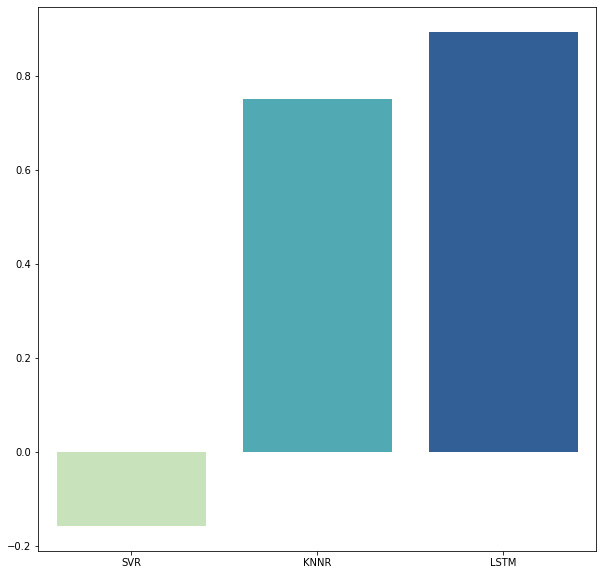

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(x=x_chart,y=y_chart,palette="YlGnBu")

In [ ]:
#@title
from pandas_profiling import ProfileReport